# Pre-Processing and Training Data

### Note that some scaling and transforming occurred in the updated EDA capstone <a href="https://github.com/trentleslie/Springboard/blob/main/16.3%20Capstone%20Two%20-%20Pre-processing%20and%20Training%20Data%20Development/2_exploratory_data_analysis.ipynb">here</a>.

## Imports

In [5]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import lazypredict
from lazypredict.Supervised import LazyRegressor

#from library.sb_utils import save_file

## Load Data

In [6]:
batch_data = pd.read_csv('../data/processed/batch_data_clean_log.csv')
print(batch_data.head())
batch_data_dropna = batch_data.dropna()

recipe_data = pd.read_csv('../data/processed/recipe_data_clean_log.csv')
print(recipe_data.head())
recipe_data_dropna = recipe_data.dropna()

   rcp_id  base_malt_pct_log  Boil Kettle_log  Whirlpool_log  Fermenter_log  \
0     102               0.47             0.79           0.22           0.54   
1     102               0.47             0.79           0.22           0.54   
2     102               0.47             0.79           0.22           0.54   
3     102               0.47             0.79           0.22           0.54   
4     102               0.47             0.79           0.22           0.54   

   Total Hops_log  fermenter_temperature_log  cu_low_log  cu_high_log  \
0            0.76                       0.02        0.97         0.93   
1            0.76                       0.02        0.97         0.93   
2            0.76                       1.12       -0.29        -0.47   
3            0.76                       1.12        0.58         1.13   
4            0.76                       0.11        0.28         1.13   

   cu_setpoint_log  pre_run_dump_volume_log  original_gravity_log  \
0            -0.7

<AxesSubplot:>

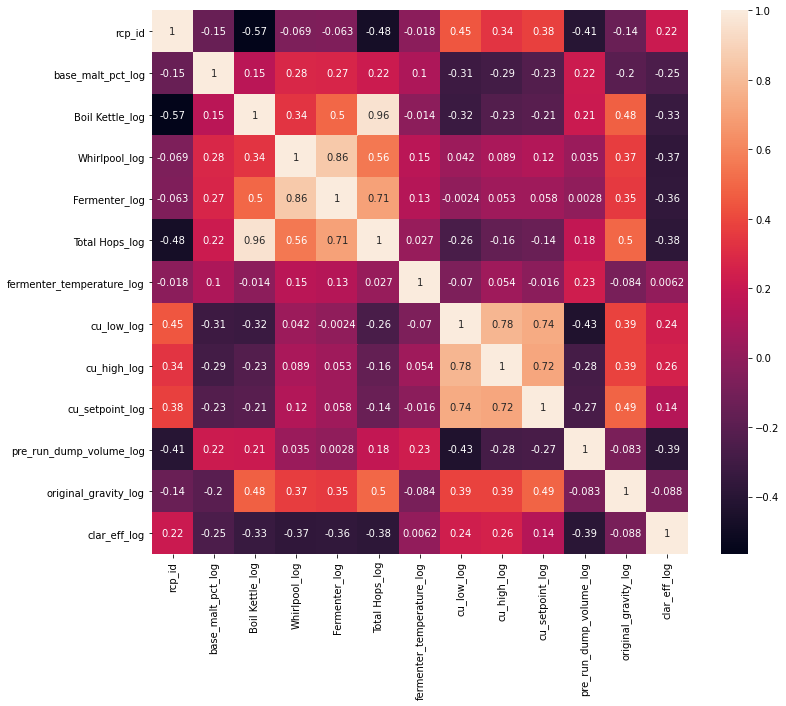

In [134]:
#Generating correlation heatmap for batch-based data
plt.subplots(figsize=(12,10))
sns.heatmap(batch_data_dropna.corr(), annot=True)

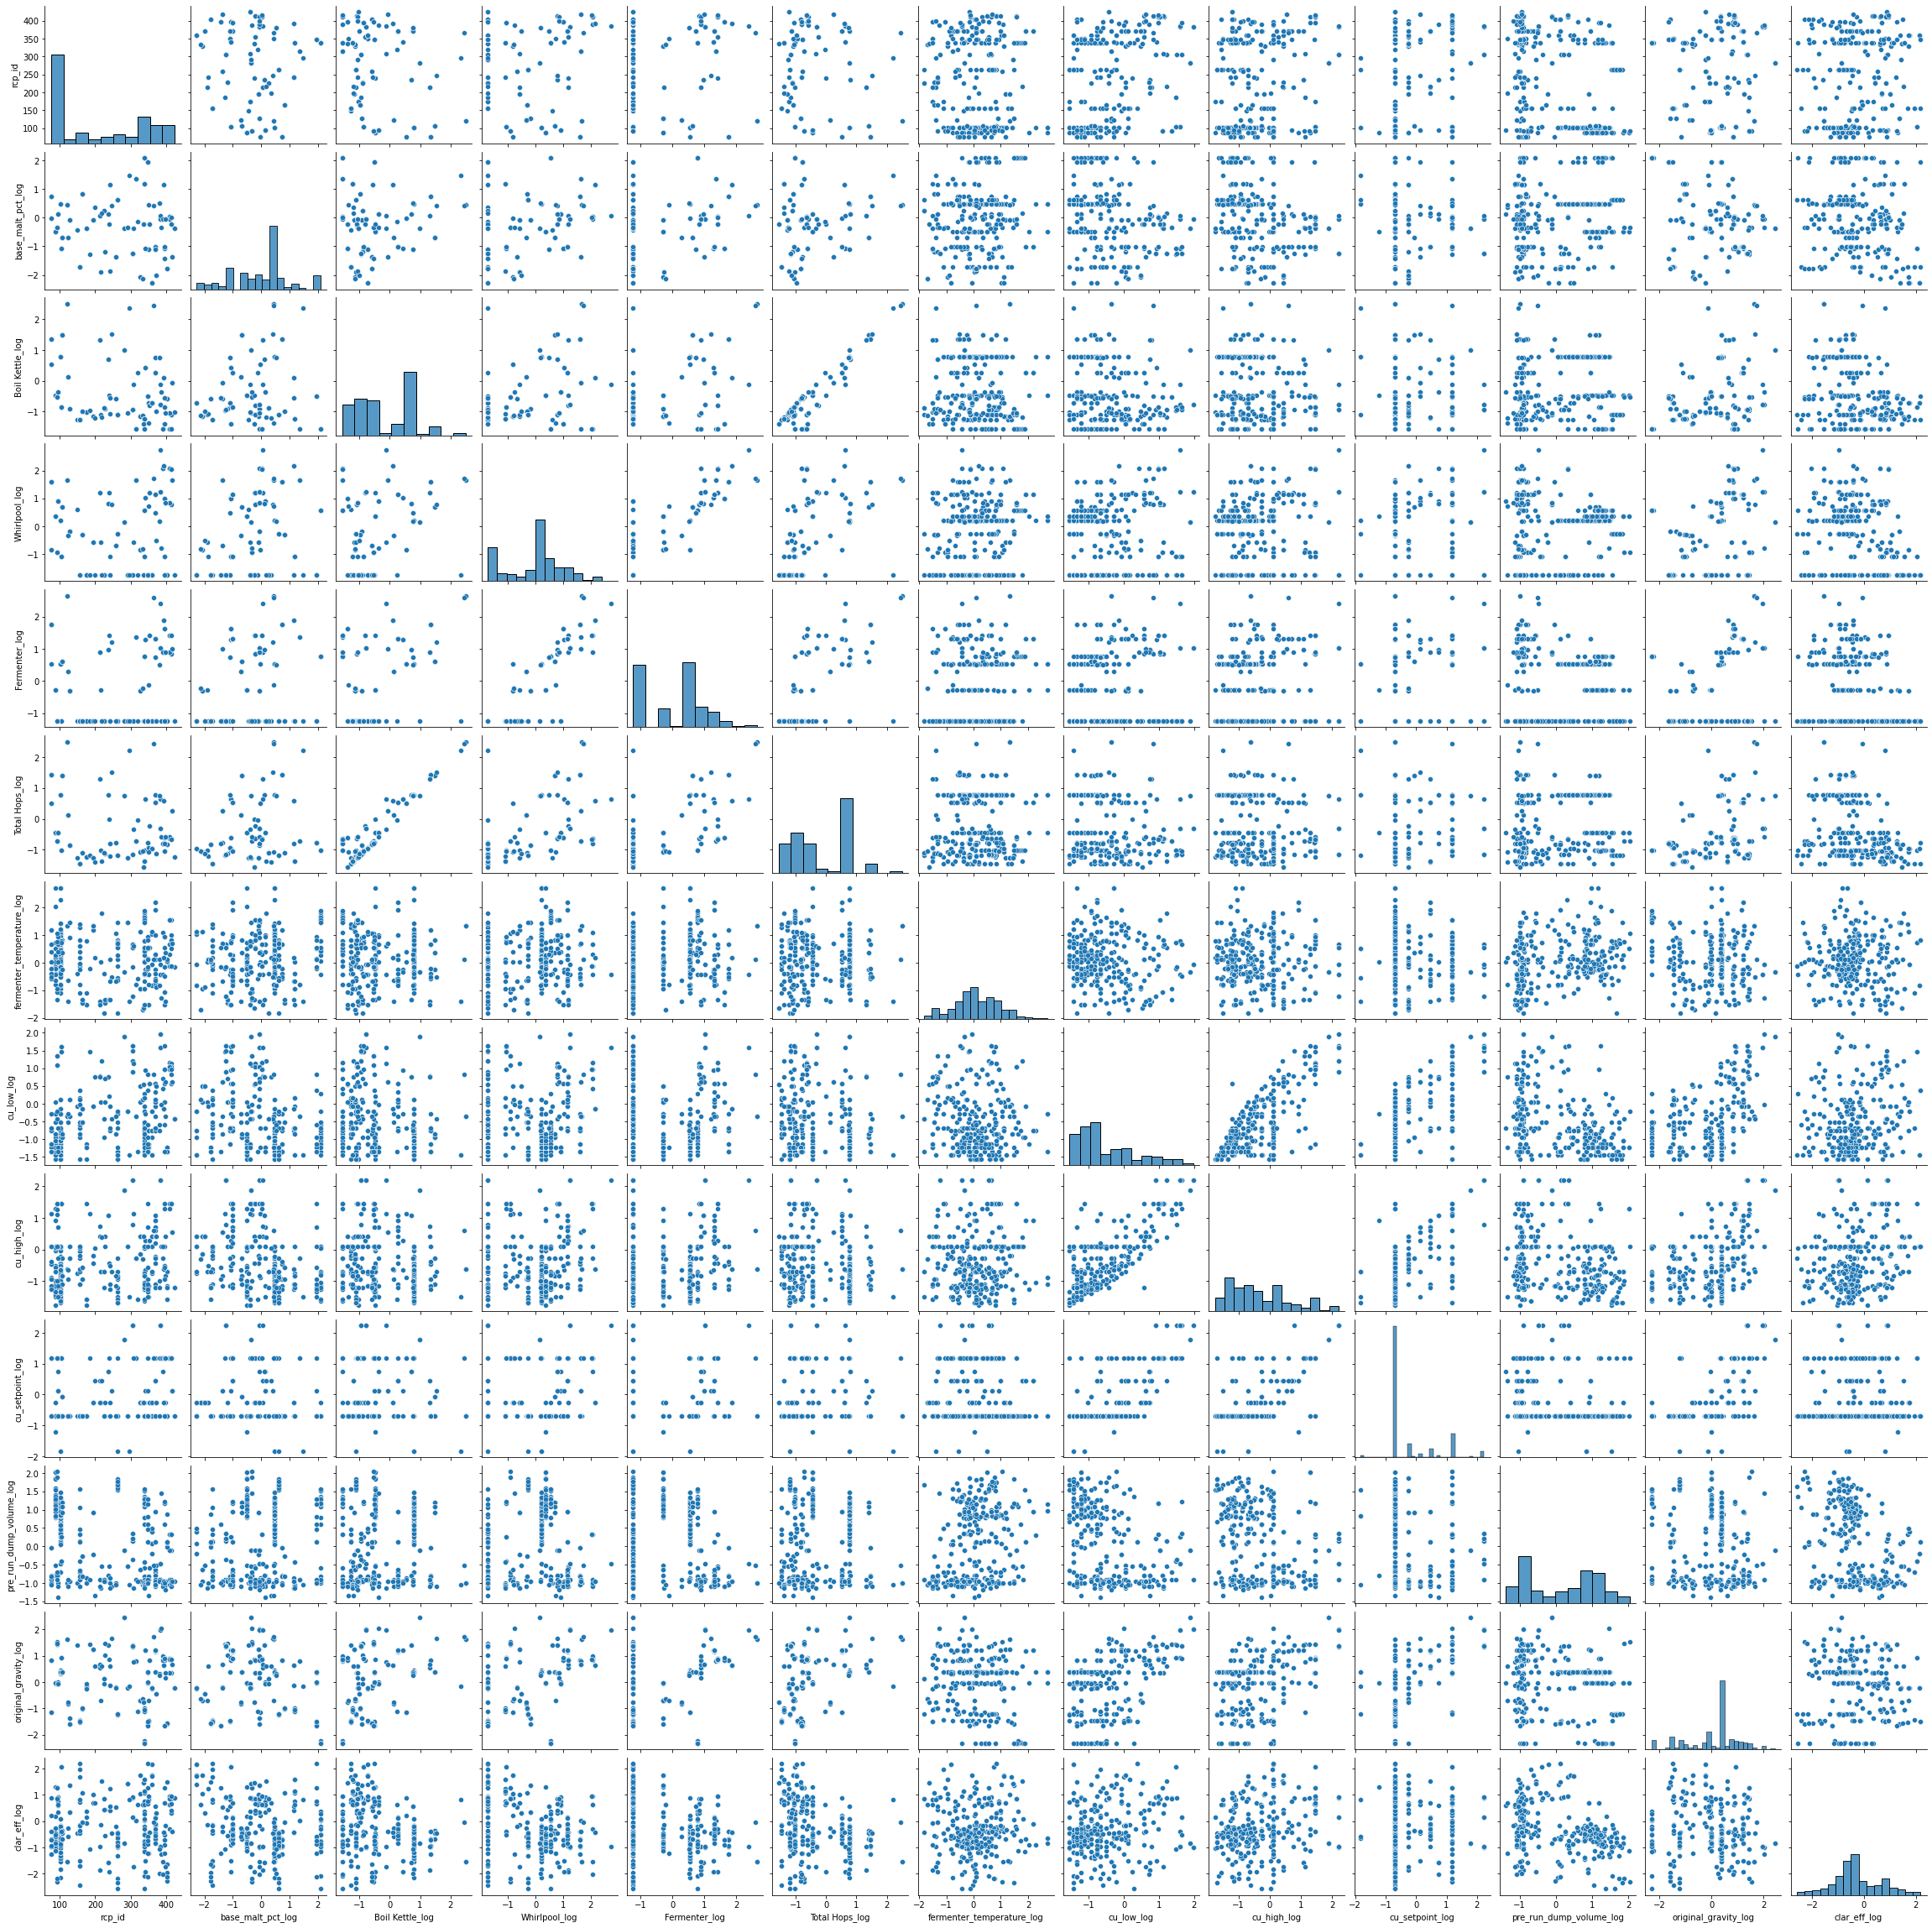

In [135]:
#Create a pairplot for all numeric variables in batch data
sns.pairplot(batch_data_dropna,  palette='Set1')
plt.show()

In [7]:
missing = pd.concat([batch_data.isnull().sum(), 100 * batch_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%',ascending=False)

,count,%
pre_run_dump_volume_log,560,50.31
Whirlpool_log,292,26.24
Boil Kettle_log,288,25.88
Fermenter_log,288,25.88
Total Hops_log,288,25.88
cu_low_log,55,4.94
fermenter_temperature_log,27,2.43
cu_high_log,21,1.89
cu_setpoint_log,8,0.72
base_malt_pct_log,1,0.09


In [8]:
print(batch_data.shape)
print(recipe_data.shape)

(1113, 13)
(269, 13)


### The rcp_id is a nominal category, not really an integer, so get_dummies() will be implemented.
### In practice, however, this won't help predict any new recipes. So I'm leaving rcp_id out of further model analysis.

In [9]:
batch_data_dummies = batch_data.merge(pd.get_dummies(batch_data['rcp_id']), left_index=True, right_index=True)
batch_data_dummies.head()

,rcp_id,base_malt_pct_log,Boil Kettle_log,Whirlpool_log,Fermenter_log,Total Hops_log,fermenter_temperature_log,cu_low_log,cu_high_log,cu_setpoint_log,...,418,419,420,421,422,423,424,425,428,429
0,102,0.47,0.79,0.22,0.54,0.76,0.02,0.97,0.93,-0.71,...,0,0,0,0,0,0,0,0,0,0
1,102,0.47,0.79,0.22,0.54,0.76,0.02,0.97,0.93,-0.71,...,0,0,0,0,0,0,0,0,0,0
2,102,0.47,0.79,0.22,0.54,0.76,1.12,-0.29,-0.47,-0.71,...,0,0,0,0,0,0,0,0,0,0
3,102,0.47,0.79,0.22,0.54,0.76,1.12,0.58,1.13,0.74,...,0,0,0,0,0,0,0,0,0,0
4,102,0.47,0.79,0.22,0.54,0.76,0.11,0.28,1.13,2.59,...,0,0,0,0,0,0,0,0,0,0


In [10]:
recipe_data_dummies = recipe_data.merge(pd.get_dummies(recipe_data['rcp_id']), left_index=True, right_index=True)
recipe_data_dummies.head()

,rcp_id,base_malt_pct_log,Boil Kettle_log,Whirlpool_log,Fermenter_log,Total Hops_log,fermenter_temperature_log,cu_low_log,cu_high_log,cu_setpoint_log,...,418,419,420,421,422,423,424,425,428,429
0,75,0.92,1.49,1.22,1.49,1.53,0.76,-0.80,-0.18,-0.08,...,0,0,0,0,0,0,0,0,0,0
1,76,0.32,0.87,-0.63,0.70,0.81,0.60,-0.45,0.00,0.25,...,0,0,0,0,0,0,0,0,0,0
2,78,1.20,nan,nan,nan,nan,0.36,-0.17,0.09,-0.08,...,0,0,0,0,0,0,0,0,0,0
3,87,-0.09,-0.12,0.32,-0.01,-0.13,0.36,-0.73,-0.25,-0.89,...,0,0,0,0,0,0,0,0,0,0
4,89,0.09,-0.44,-0.87,-1.01,-0.74,2.09,-0.03,0.00,-0.26,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# removing rcp_id
batch_data = batch_data.drop('rcp_id', 1)
recipe_data = recipe_data.drop('rcp_id', 1)

## Train/Test Split

### Partition sizes for a 70/30 train/test split

In [12]:
len(batch_data) * .7, len(batch_data) * .3, len(recipe_data) * .7, len(recipe_data) * .3

(779.0999999999999, 333.9, 188.29999999999998, 80.7)

In [13]:
Xbatch_train, Xbatch_test, ybatch_train, ybatch_test = train_test_split(batch_data.drop(columns='clar_eff_log'), 
                                                    batch_data.clar_eff_log, test_size=0.3, 
                                                    random_state=47)
                            
Xrcp_train, Xrcp_test, yrcp_train, yrcp_test = train_test_split(recipe_data.drop(columns='clar_eff_log'), 
                                                    recipe_data.clar_eff_log, test_size=0.3, 
                                                    random_state=47)

Xbatch_train_dropna, Xbatch_test_dropna, ybatch_train_dropna, ybatch_test_dropna = train_test_split(batch_data_dropna.drop(columns='clar_eff_log'), 
                                                    batch_data_dropna.clar_eff_log, test_size=0.3, 
                                                    random_state=47)
                            
Xrcp_train_dropna, Xrcp_test_dropna, yrcp_train_dropna, yrcp_test_dropna = train_test_split(recipe_data_dropna.drop(columns='clar_eff_log'), 
                                                    recipe_data_dropna.clar_eff_log, test_size=0.3, 
                                                    random_state=47)

In [14]:
Xbatch_train.shape, Xbatch_test.shape, Xrcp_train.shape, Xrcp_test.shape, Xbatch_train_dropna.shape, Xbatch_test_dropna.shape, Xrcp_train_dropna.shape, Xrcp_test_dropna.shape

((779, 11),
 (334, 11),
 (188, 11),
 (81, 11),
 (277, 12),
 (119, 12),
 (49, 12),
 (21, 12))

In [15]:
ybatch_train.shape, ybatch_test.shape, yrcp_train.shape, yrcp_test.shape, ybatch_train_dropna.shape, ybatch_test_dropna.shape, yrcp_train_dropna.shape, yrcp_test_dropna.shape

((779,), (334,), (188,), (81,), (277,), (119,), (49,), (21,))

In [16]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
Xbatch_train.dtypes, Xrcp_train.dtypes

(base_malt_pct_log            float64
 Boil Kettle_log              float64
 Whirlpool_log                float64
 Fermenter_log                float64
 Total Hops_log               float64
 fermenter_temperature_log    float64
 cu_low_log                   float64
 cu_high_log                  float64
 cu_setpoint_log              float64
 pre_run_dump_volume_log      float64
 original_gravity_log         float64
 dtype: object,
 base_malt_pct_log            float64
 Boil Kettle_log              float64
 Whirlpool_log                float64
 Fermenter_log                float64
 Total Hops_log               float64
 fermenter_temperature_log    float64
 cu_low_log                   float64
 cu_high_log                  float64
 cu_setpoint_log              float64
 pre_run_dump_volume_log      float64
 original_gravity_log         float64
 dtype: object)

In [17]:
#Code task 3#
#Repeat this check for the test split in `X_test`
Xbatch_test.dtypes, Xrcp_test.dtypes

(base_malt_pct_log            float64
 Boil Kettle_log              float64
 Whirlpool_log                float64
 Fermenter_log                float64
 Total Hops_log               float64
 fermenter_temperature_log    float64
 cu_low_log                   float64
 cu_high_log                  float64
 cu_setpoint_log              float64
 pre_run_dump_volume_log      float64
 original_gravity_log         float64
 dtype: object,
 base_malt_pct_log            float64
 Boil Kettle_log              float64
 Whirlpool_log                float64
 Fermenter_log                float64
 Total Hops_log               float64
 fermenter_temperature_log    float64
 cu_low_log                   float64
 cu_high_log                  float64
 cu_setpoint_log              float64
 pre_run_dump_volume_log      float64
 original_gravity_log         float64
 dtype: object)

## Initial Not-Even-A-Model<a id='4.7_Initial_Not-Even-A-Model'></a>

### Using the mean is as a predictor.

In [18]:
#Code task 4#
#Calculate the mean of `y_train`
batch_train_mean = ybatch_train.mean()
rcp_train_mean = yrcp_train.mean()
batch_train_mean, rcp_train_mean

(0.009310898472114526, -0.013505455739161308)

`sklearn`'s `DummyRegressor` easily does this:

In [19]:
#Code task 5#
#Fit the dummy regressor on the training data
#Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mean above
batch_dumb_reg = DummyRegressor(strategy='mean')
batch_dumb_reg.fit(Xbatch_train, ybatch_train)
rcp_dumb_reg = DummyRegressor(strategy='mean')
rcp_dumb_reg.fit(Xrcp_train, yrcp_train)

batch_dumb_reg.constant_, rcp_dumb_reg.constant_

(array([[0.0093109]]), array([[-0.01350546]]))

### 4.7.1 Metrics<a id='4.7.1_Metrics'></a>

In [20]:
batch_y_tr_pred = batch_dumb_reg.predict(Xbatch_train)
rcp_y_tr_pred = rcp_dumb_reg.predict(Xrcp_train)
batch_y_tr_pred[:5], rcp_y_tr_pred[:5]

(array([0.0093109, 0.0093109, 0.0093109, 0.0093109, 0.0093109]),
 array([-0.01350546, -0.01350546, -0.01350546, -0.01350546, -0.01350546]))

In [21]:
batch_y_te_pred = batch_train_mean * np.ones(len(ybatch_test))
rcp_y_te_pred = rcp_train_mean * np.ones(len(yrcp_test))

##### 4.7.2.0.1 R-squared<a id='4.7.2.0.1_R-squared'></a>

In [22]:
r2_score(ybatch_train, batch_y_tr_pred), r2_score(ybatch_test, batch_y_te_pred), r2_score(yrcp_train, rcp_y_tr_pred), r2_score(yrcp_test, rcp_y_te_pred)

(0.0, -0.0009052583542255022, 0.0, -0.0019081517391161817)

##### 4.7.2.0.2 Mean absolute error<a id='4.7.2.0.2_Mean_absolute_error'></a>

In [23]:
mean_absolute_error(ybatch_train, batch_y_tr_pred), mean_absolute_error(ybatch_test, batch_y_te_pred), mean_absolute_error(yrcp_train, rcp_y_tr_pred), mean_absolute_error(yrcp_test, rcp_y_te_pred)

(0.7968636591177362,
 0.8242619528296811,
 0.7965560575169336,
 0.8430146427718417)

##### 4.7.2.0.3 Mean squared error<a id='4.7.2.0.3_Mean_squared_error'></a>

In [24]:
mean_squared_error(ybatch_train, batch_y_tr_pred), mean_squared_error(ybatch_test, batch_y_te_pred), mean_squared_error(yrcp_train, rcp_y_tr_pred), mean_squared_error(yrcp_test, rcp_y_te_pred)

(0.9725161082134292,
 1.0643905413830161,
 0.9760242584331331,
 1.0562531394766825)

## 4.8 Initial Models<a id='4.8_Initial_Models'></a>

### 4.8.1 Imputing missing feature (predictor) values<a id='4.8.1_Imputing_missing_feature_(predictor)_values'></a>

There's missing values. Recall from your data exploration that many distributions were skewed. Your first thought might be to impute missing values using the median.

#### No impute - drop NA values

In [25]:
Xbatch_tr = Xbatch_train_dropna
Xbatch_te = Xbatch_test_dropna

Xrcp_tr = Xrcp_train_dropna
Xrcp_te = Xrcp_test_dropna

In [26]:
scaler_batch = StandardScaler()
scaler_batch.fit(Xbatch_tr)
Xbatch_tr_scaled = scaler_batch.transform(Xbatch_tr)
Xbatch_te_scaled = scaler_batch.transform(Xbatch_te)

scaler_rcp = StandardScaler()
scaler_rcp.fit(Xrcp_tr)
Xrcp_tr_scaled = scaler_rcp.transform(Xrcp_tr)
Xrcp_te_scaled = scaler_rcp.transform(Xrcp_te)

In [27]:
lm_batch = LinearRegression().fit(Xbatch_tr_scaled, ybatch_train_dropna)

lm_rcp = LinearRegression().fit(Xrcp_tr_scaled, yrcp_train_dropna)

In [28]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
ybatch_tr_pred = lm_batch.predict(Xbatch_tr_scaled)
ybatch_te_pred = lm_batch.predict(Xbatch_te_scaled)

yrcp_tr_pred = lm_rcp.predict(Xrcp_tr_scaled)
yrcp_te_pred = lm_rcp.predict(Xrcp_te_scaled)

In [29]:
# r^2 - train, test
dropna_r2_batch = r2_score(ybatch_train_dropna, ybatch_tr_pred), r2_score(ybatch_test_dropna, ybatch_te_pred)
print(dropna_r2_batch)

dropna_r2_rcp = r2_score(yrcp_train_dropna, yrcp_tr_pred), r2_score(yrcp_test_dropna, yrcp_te_pred)
print(dropna_r2_rcp)

(0.3110499542627596, 0.39265331445711527)
(0.6086476720558178, -0.06923998256364872)


In [30]:
#Code task 12#
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
dropna_mae = mean_absolute_error(ybatch_train_dropna, ybatch_tr_pred), mean_absolute_error(ybatch_test_dropna, ybatch_te_pred)
print(dropna_mae)

dropna_mae = mean_absolute_error(yrcp_train_dropna, yrcp_tr_pred), mean_absolute_error(yrcp_test_dropna, yrcp_te_pred)
print(dropna_mae)

(0.5611322615089411, 0.5961068007932)
(0.5029578419982738, 0.9070449565247036)


#### Impute missing values with median

In [31]:
Xbatch_tr = Xbatch_train
Xbatch_te = Xbatch_test

Xrcp_tr = Xrcp_train
Xrcp_te = Xrcp_test

In [32]:
# These are the values we'll use to fill in any missing values
Xbatch_defaults_median = Xbatch_train.median()
Xrcp_defaults_median = Xrcp_train.median()

Xbatch_defaults_median, Xrcp_defaults_median

(base_malt_pct_log            0.31
 Boil Kettle_log              0.18
 Whirlpool_log                0.22
 Fermenter_log                0.54
 Total Hops_log               0.34
 fermenter_temperature_log    0.02
 cu_low_log                  -0.08
 cu_high_log                  0.04
 cu_setpoint_log             -0.26
 pre_run_dump_volume_log     -0.10
 original_gravity_log         0.36
 dtype: float64,
 base_malt_pct_log            0.01
 Boil Kettle_log             -0.44
 Whirlpool_log                0.08
 Fermenter_log                0.00
 Total Hops_log              -0.37
 fermenter_temperature_log    0.09
 cu_low_log                  -0.14
 cu_high_log                  0.00
 cu_setpoint_log             -0.08
 pre_run_dump_volume_log     -0.28
 original_gravity_log        -0.13
 dtype: float64)

In [33]:
#Code task 9#
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
Xbatch_tr = Xbatch_train.fillna(Xbatch_defaults_median)
Xbatch_te = Xbatch_test.fillna(Xbatch_defaults_median)

Xrcp_tr = Xrcp_train.fillna(Xrcp_defaults_median)
Xrcp_te = Xrcp_test.fillna(Xrcp_defaults_median)

In [34]:
#Code task 10#
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler_batch = StandardScaler()
scaler_batch.fit(Xbatch_tr)
Xbatch_tr_scaled = scaler_batch.transform(Xbatch_tr)
Xbatch_te_scaled = scaler_batch.transform(Xbatch_te)

scaler_rcp = StandardScaler()
scaler_rcp.fit(Xrcp_tr)
Xrcp_tr_scaled = scaler_rcp.transform(Xrcp_tr)
Xrcp_te_scaled = scaler_rcp.transform(Xrcp_te)

In [35]:
lm_batch = LinearRegression().fit(Xbatch_tr_scaled, ybatch_train)

lm_rcp = LinearRegression().fit(Xrcp_tr_scaled, yrcp_train)

In [36]:
#Code task 11#
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
ybatch_tr_pred = lm_batch.predict(Xbatch_tr_scaled)
ybatch_te_pred = lm_batch.predict(Xbatch_te_scaled)

yrcp_tr_pred = lm_rcp.predict(Xrcp_tr_scaled)
yrcp_te_pred = lm_rcp.predict(Xrcp_te_scaled)

In [37]:
# r^2 - train, test
median_r2_batch = r2_score(ybatch_train, ybatch_tr_pred), r2_score(ybatch_test, ybatch_te_pred)
print(median_r2_batch)

median_r2_rcp = r2_score(yrcp_train, yrcp_tr_pred), r2_score(yrcp_test, yrcp_te_pred)
print(median_r2_rcp)

(0.30061205065929497, 0.2369314265012885)
(0.25707156479020377, 0.08964668357850025)


In [38]:
#Code task 12#
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae_batch = mean_absolute_error(ybatch_train, ybatch_tr_pred), mean_absolute_error(ybatch_test, ybatch_te_pred)
print(median_mae_batch)

median_mae_rcp = mean_absolute_error(yrcp_train, yrcp_tr_pred), mean_absolute_error(yrcp_test, yrcp_te_pred)
print(median_mae_rcp)

(0.6204214777223807, 0.6787206227504838)
(0.6710918182791089, 0.7634597732879359)


In [39]:
#Code task 13#
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse_batch = mean_squared_error(ybatch_train, ybatch_tr_pred), mean_squared_error(ybatch_test, ybatch_te_pred)
print(median_mse_batch)

median_mse_rcp = mean_squared_error(yrcp_train, yrcp_tr_pred), mean_squared_error(yrcp_test, yrcp_te_pred)
print(median_mse_rcp)

(0.6801660466241934, 0.8114683835252833)
(0.7251161750445293, 0.9597322337722605)


#### Impute missing values with the mean

In [40]:
#Code task 14#
#As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
Xbatch_defaults_mean = Xbatch_train.mean()
Xrcp_defaults_mean = Xrcp_train.mean()

Xbatch_defaults_mean, Xrcp_defaults_mean

(base_malt_pct_log            0.03
 Boil Kettle_log              0.02
 Whirlpool_log               -0.01
 Fermenter_log                0.02
 Total Hops_log               0.02
 fermenter_temperature_log   -0.03
 cu_low_log                  -0.02
 cu_high_log                 -0.01
 cu_setpoint_log             -0.01
 pre_run_dump_volume_log      0.03
 original_gravity_log         0.02
 dtype: float64,
 base_malt_pct_log           -0.04
 Boil Kettle_log             -0.11
 Whirlpool_log                0.01
 Fermenter_log                0.00
 Total Hops_log              -0.09
 fermenter_temperature_log   -0.06
 cu_low_log                   0.03
 cu_high_log                  0.01
 cu_setpoint_log             -0.00
 pre_run_dump_volume_log      0.01
 original_gravity_log        -0.04
 dtype: float64)

In [41]:
Xbatch_tr = Xbatch_train.fillna(Xbatch_defaults_mean)
Xbatch_te = Xbatch_test.fillna(Xbatch_defaults_mean)

Xrcp_tr = Xrcp_train.fillna(Xrcp_defaults_mean)
Xrcp_te = Xrcp_test.fillna(Xrcp_defaults_mean)

In [42]:
scaler_batch = StandardScaler()
scaler_batch.fit(Xbatch_tr)
Xbatch_tr_scaled = scaler_batch.transform(Xbatch_tr)
Xbatch_te_scaled = scaler_batch.transform(Xbatch_te)

scaler_rcp = StandardScaler()
scaler_rcp.fit(Xrcp_tr)
Xrcp_tr_scaled = scaler_rcp.transform(Xrcp_tr)
Xrcp_te_scaled = scaler_rcp.transform(Xrcp_te)

In [43]:
lm_batch = LinearRegression().fit(Xbatch_tr_scaled, ybatch_train)

lm_rcp = LinearRegression().fit(Xrcp_tr_scaled, yrcp_train)

In [44]:
ybatch_tr_pred = lm_batch.predict(Xbatch_tr_scaled)
ybatch_te_pred = lm_batch.predict(Xbatch_te_scaled)

yrcp_tr_pred = lm_rcp.predict(Xrcp_tr_scaled)
yrcp_te_pred = lm_rcp.predict(Xrcp_te_scaled)

In [45]:
mean_r2_batch = r2_score(ybatch_train, ybatch_tr_pred), r2_score(ybatch_test, ybatch_te_pred)
print(mean_r2_batch)

mean_r2_rcp = r2_score(yrcp_train, yrcp_tr_pred), r2_score(yrcp_test, yrcp_te_pred)
print(mean_r2_rcp)

(0.29534881081674924, 0.22155475520568169)
(0.2619535905063797, 0.06510573402577069)


In [46]:
mean_mae_batch = mean_absolute_error(ybatch_train, ybatch_tr_pred), mean_absolute_error(ybatch_test, ybatch_te_pred)
print(mean_mae_batch)

mean_mae_rcp = mean_absolute_error(yrcp_train, yrcp_tr_pred), mean_absolute_error(yrcp_test, yrcp_te_pred)
print(mean_mae_rcp)

(0.6252445496498902, 0.6841036798245843)
(0.6657255057749036, 0.7771347827452417)


In [47]:
mean_mse_batch = mean_squared_error(ybatch_train, ybatch_tr_pred), mean_squared_error(ybatch_test, ybatch_te_pred)
print(mean_mse_batch)

mean_mse_rcp = mean_squared_error(yrcp_train, yrcp_tr_pred), mean_squared_error(yrcp_test, yrcp_te_pred)
print(mean_mse_rcp)

(0.6852846321524598, 0.82782036424313)
(0.7203511995152474, 0.9856043209149941)


#### lazypredict with dropna

In [48]:
Xbatch_tr = Xbatch_train_dropna
Xbatch_te = Xbatch_test_dropna

Xrcp_tr = Xrcp_train_dropna
Xrcp_te = Xrcp_test_dropna

In [52]:
print(Xbatch_tr.shape)
print(Xbatch_te.shape)
print(ybatch_train.shape)
print(ybatch_test.shape)

(277, 12)
(119, 12)
(779,)
(334,)


In [53]:
reg_batch_dropna = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_batch_dropna, predictions_batch_dropna = reg_batch_dropna.fit(Xbatch_tr, Xbatch_te, ybatch_train_dropna, ybatch_test_dropna)

#reg_rcp_dropna = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models_rcp_dropna, predictions_rcp_dropna = reg_rcp_dropna.fit(Xrcp_tr, Xrcp_te, yrcp_train, yrcp_test)

 26%|██▌       | 11/42 [00:00<00:01, 28.20it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 64%|██████▍   | 27/42 [00:01<00:00, 15.45it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


100%|██████████| 42/42 [00:02<00:00, 20.57it/s]


In [54]:
print(models_batch_dropna)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.59       0.63  0.61        0.12
RandomForestRegressor                        0.57       0.61  0.62        0.17
LGBMRegressor                                0.57       0.61  0.63        0.04
HistGradientBoostingRegressor                0.54       0.59  0.65        0.45
BaggingRegressor                             0.53       0.58  0.65        0.03
GradientBoostingRegressor                    0.50       0.55  0.67        0.06
NuSVR                                        0.49       0.54  0.68        0.01
SVR                                          0.47       0.52  0.70        0.01
AdaBoostRegressor                            0.46       0.52  0.70        0.08
XGBRegressor                                 0.45       0.50  0.71        0.13
MLPRegressor                                 0.43   

### Not really sure what's going on here, but given the number of rows to begin with, it's probably a good idea to impute rather than drop anyway.

#### lazypredict with median impute

In [232]:
Xbatch_tr = Xbatch_train.fillna(Xbatch_defaults_median)
Xbatch_te = Xbatch_test.fillna(Xbatch_defaults_median)

Xrcp_tr = Xrcp_train.fillna(Xrcp_defaults_median)
Xrcp_te = Xrcp_test.fillna(Xrcp_defaults_median)

In [148]:
reg_batch = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_batch, predictions_batch = reg_batch.fit(Xbatch_tr, Xbatch_te, ybatch_train, ybatch_test)

reg_rcp = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_rcp, predictions_rcp = reg_rcp.fit(Xrcp_tr, Xrcp_te, yrcp_train, yrcp_test)

 31%|███       | 13/42 [00:00<00:01, 19.06it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 79%|███████▊  | 33/42 [00:02<00:00, 13.52it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 29%|██▊       | 12/42 [00:00<00:00, 32.32it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 81%|████████  | 34/42 [00:01<00:00, 25.29it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


100%|██████████| 42/42 [00:01<00:00, 28.14it/s]


In [149]:
print(models_batch)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.57       0.58  0.67        0.22
RandomForestRegressor                        0.55       0.57  0.68        0.32
XGBRegressor                                 0.52       0.54  0.70        0.06
BaggingRegressor                             0.51       0.52  0.71        0.05
HistGradientBoostingRegressor                0.48       0.50  0.73        0.62
GradientBoostingRegressor                    0.48       0.50  0.73        0.11
LGBMRegressor                                0.46       0.48  0.74        0.05
MLPRegressor                                 0.38       0.40  0.80        0.86
KNeighborsRegressor                          0.38       0.40  0.80        0.02
NuSVR                                        0.36       0.38  0.81        0.04
SVR                                          0.36   

In [150]:
print(models_rcp)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.06       0.19  0.93        0.13
SVR                                          0.03       0.16  0.94        0.01
LGBMRegressor                                0.02       0.15  0.94        0.03
KNeighborsRegressor                          0.01       0.15  0.95        0.01
NuSVR                                        0.01       0.14  0.95        0.01
AdaBoostRegressor                           -0.02       0.12  0.96        0.08
BayesianRidge                               -0.04       0.10  0.97        0.01
RandomForestRegressor                       -0.05       0.10  0.98        0.15
ElasticNetCV                                -0.05       0.10  0.98        0.06
SGDRegressor                                -0.05       0.10  0.98        0.01
TweedieRegressor                            -0.05   

### Just using the recipe data set is worthless. Looks like the batch data set is going to be the best bet.

#### lazypredict with mean impute (not even looking at recipe data any more)

In [55]:
Xbatch_tr = Xbatch_train.fillna(Xbatch_defaults_mean)
Xbatch_te = Xbatch_test.fillna(Xbatch_defaults_mean)


In [56]:
reg_batch = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_batch, predictions_batch = reg_batch.fit(Xbatch_tr, Xbatch_te, ybatch_train, ybatch_test)


 31%|███       | 13/42 [00:00<00:01, 19.69it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 79%|███████▊  | 33/42 [00:02<00:00, 11.42it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


100%|██████████| 42/42 [00:03<00:00, 11.95it/s]


In [57]:
print(models_batch)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.57       0.58  0.67        0.21
RandomForestRegressor                        0.55       0.56  0.68        0.31
XGBRegressor                                 0.48       0.50  0.73        0.07
BaggingRegressor                             0.48       0.50  0.73        0.05
HistGradientBoostingRegressor                0.47       0.49  0.74        1.04
LGBMRegressor                                0.47       0.49  0.74        0.07
GradientBoostingRegressor                    0.46       0.47  0.75        0.10
MLPRegressor                                 0.39       0.41  0.79        0.97
SVR                                          0.36       0.38  0.81        0.03
NuSVR                                        0.36       0.38  0.81        0.04
KNeighborsRegressor                          0.35   

## Looking at the ExtraTreesRegressor()

In [78]:
#moving forward with dropped missing values
Xbatch_tr = Xbatch_train_dropna
ybatch_train = ybatch_train_dropna
Xbatch_te = Xbatch_test_dropna
ybatch_test = ybatch_test_dropna

pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    ExtraTreesRegressor()
)

In [79]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(Xbatch_tr, ybatch_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('extratreesregressor', ExtraTreesRegressor())])

In [80]:
y_tr_pred = pipe.predict(Xbatch_tr)
y_te_pred = pipe.predict(Xbatch_te)

In [81]:
#R-squared
r2_score(ybatch_train, y_tr_pred), r2_score(ybatch_test, y_te_pred)

(1.0, 0.6152366604451627)

In [82]:
#MAE
mean_absolute_error(ybatch_train, y_tr_pred), mean_absolute_error(ybatch_test, y_te_pred)

(1.0045739811604319e-15, 0.2895936923943102)

In [83]:
#MSE
mean_squared_error(ybatch_train, y_tr_pred), mean_squared_error(ybatch_test, y_te_pred)

(1.9253993141852748e-30, 0.3877918820004232)

## Refining The ExtraTreesRegressor Model

In [84]:
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=8),
    ExtraTreesRegressor()
)

In [85]:
pipe.fit(Xbatch_tr, ybatch_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x000001B64A99E280>)),
                ('extratreesregressor', ExtraTreesRegressor())])

In [86]:
y_tr_pred = pipe.predict(Xbatch_tr)
y_te_pred = pipe.predict(Xbatch_te)

In [87]:
r2_score(ybatch_train, y_tr_pred), r2_score(ybatch_test, y_te_pred)

(1.0, 0.5784954193020663)

In [88]:
mean_absolute_error(ybatch_train, y_tr_pred), mean_absolute_error(ybatch_test, y_te_pred)

(1.0045739811604319e-15, 0.3218819895605906)

## Assessing performance using cross-validation

In [89]:
cv_results = cross_validate(pipe, Xbatch_tr, ybatch_train, cv=5)

In [90]:
cv_scores = cv_results['test_score']
cv_scores

array([0.30068941, 0.61593672, 0.5518805 , 0.1884125 , 0.5836227 ])

In [91]:
np.mean(cv_scores), np.std(cv_scores)

(0.44810836708001156, 0.17115690923634785)

In [92]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.11, 0.79])

## Hyperparameter search using GridSearchCV (with Extra Trees Regressor)

In [93]:
#Code task 18#
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'extratreesregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'extratreesregressor__bootstrap', 'extratreesregressor__ccp_alpha', 'extratreesregressor__criterion', 'extratreesregressor__max_depth', 'extratreesregressor__max_features', 'extratreesregressor__max_leaf_nodes', 'extratreesregressor__max_samples', 'extratreesregressor__min_impurity_decrease', 'extratreesregressor__min_impurity_split', 'extratreesregressor__min_samples_leaf', 'extratreesregressor__min_samples_split', 'extratreesregressor__min_weight_fraction_leaf', 'extratreesregressor__n_estimators', 'extratreesregressor__n_jobs', 'extratreesregressor__oob_score', 'extratreesregresso

In [94]:
k = [k+1 for k in range(len(Xbatch_train.columns))]
grid_params = {'selectkbest__k': k}

In [95]:
etr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [98]:
etr_grid_cv.fit(Xbatch_tr, ybatch_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k=8,
                                                    score_func=<function f_regression at 0x000001B64A99E280>)),
                                       ('extratreesregressor',
                                        ExtraTreesRegressor())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]})

In [99]:
score_mean = etr_grid_cv.cv_results_['mean_test_score']
score_std = etr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in etr_grid_cv.cv_results_['param_selectkbest__k']]

In [100]:
#Code task 19#
#Print the `best_params_` attribute of `lr_grid_cv`
etr_grid_cv.best_params_

{'selectkbest__k': 9}

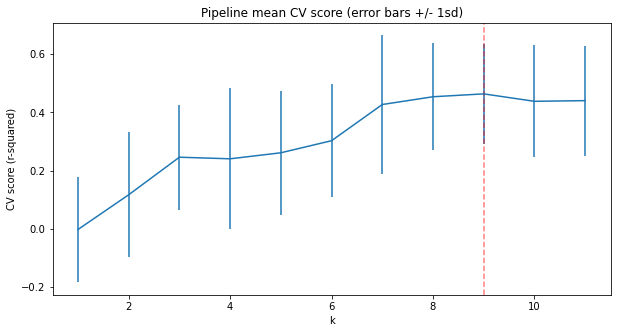

In [101]:
#Code task 20#
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = etr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

## Random Forest Model

In [102]:
#Code task 22#
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

### Fit and assess performance using cross-validation

In [103]:
#Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, Xbatch_tr, ybatch_train, cv=5)

In [104]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.30037966, 0.52101484, 0.56387236, 0.17340909, 0.66312005])

In [105]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.4443592002152238, 0.18008879170581982)

### Hyperparameter search using GridSearchCV

In [106]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [107]:
#Call `GridSearchCV` with the random forest pipeline
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [108]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(Xbatch_tr, ybatch_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [109]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 183,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [111]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, Xbatch_tr, ybatch_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.25781547, 0.52557349, 0.57099851, 0.19825082, 0.67170286])

In [112]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.44486823047794744, 0.18421998745390886)

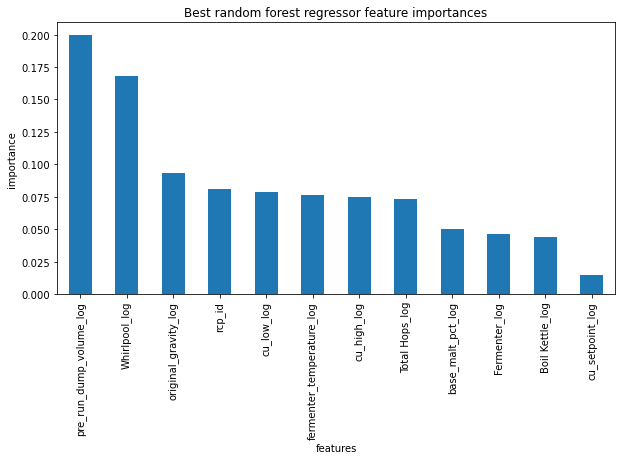

In [114]:
#Plot a barplot of the random forest's feature importances
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=Xbatch_tr.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

### Random forest regression model performance

In [116]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, Xbatch_tr, ybatch_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [117]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(0.43550442925324884, 0.07172208645080203)

In [119]:
mean_absolute_error(ybatch_test, rf_grid_cv.best_estimator_.predict(Xbatch_te))

0.3559534121062051

## 4.12 Data quantity assessment<a id='4.12_Data_quantity_assessment'></a>

In [121]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, Xbatch_tr, ybatch_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

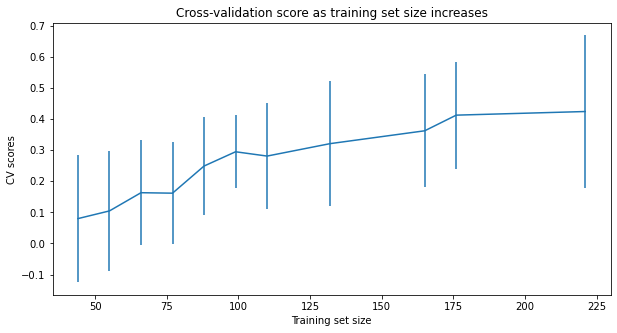

In [122]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## Save best Extra Trees model object from pipeline

In [123]:
#Model info
best_model = etr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in Xbatch_tr.columns]
best_model.build_datetime = datetime.datetime.now()

In [130]:
# save the model
import pickle
modelpath = '../models'
pickle.dump(best_model, open(os.path.join(modelpath, 'best_model.pkl'), 'wb'))